In [ ]:
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# !pip install transformers

In [ ]:
# Bert tokenizer
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
PAD_IDX = bert_tokenizer.pad_token_id
MAX_LEN = 512

c:\Users\user\anaconda3\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# read dataset 平衡 dataset
df = pd.read_csv('./AI_Human.csv', encoding='utf-8')
df = df[df['text'].astype(str).apply(lambda x: len(x.strip()) > 0)]
df_zero = df[df['generated'] == 0]
df_one = df[df['generated'] == 1]

# divide it into smaller subsets for testing
df_zero_sampled = df_zero.sample(50000, random_state=1)
df_one_sampled = df_one.sample(50000, random_state=1)

df = pd.concat([df_zero_sampled, df_one_sampled])
df.reset_index(drop=True, inplace=True)

print(f'Number of rows in data subset: {len(df)}')

Number of rows in data subset: 100000


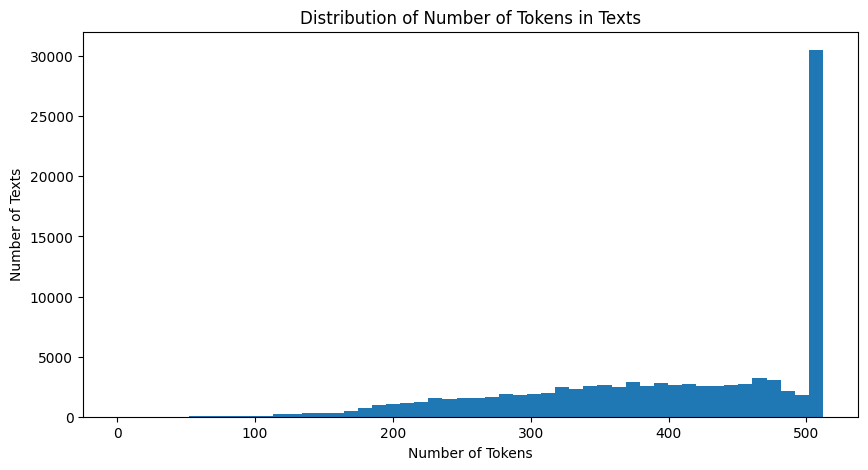

Maximum token length for the tokenizer: 512
Maximum number of tokens in a text: 512
95th percentile of number of tokens in a text: 512.0


In [ ]:

df_visualization = df.copy()
def tokenize_and_truncate(text, max_length):
    tokens = bert_tokenizer.tokenize(text)
    return tokens[:max_length]
df_visualization['tokens'] = df_visualization['text'].apply(lambda x: tokenize_and_truncate(x, MAX_LEN))
df_visualization['num_tokens'] = df_visualization['tokens'].apply(len)
plt.figure(figsize=(10, 5))

plt.hist(df_visualization['num_tokens'], bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Texts')
plt.title('Distribution of Number of Tokens in Texts')
plt.show()

print(f'Maximum token length for the tokenizer: {MAX_LEN}')
print(f"Maximum number of tokens in a text: {df_visualization['num_tokens'].max()}")
print(f"95th percentile of number of tokens in a text: {df_visualization['num_tokens'].quantile(0.95)}")

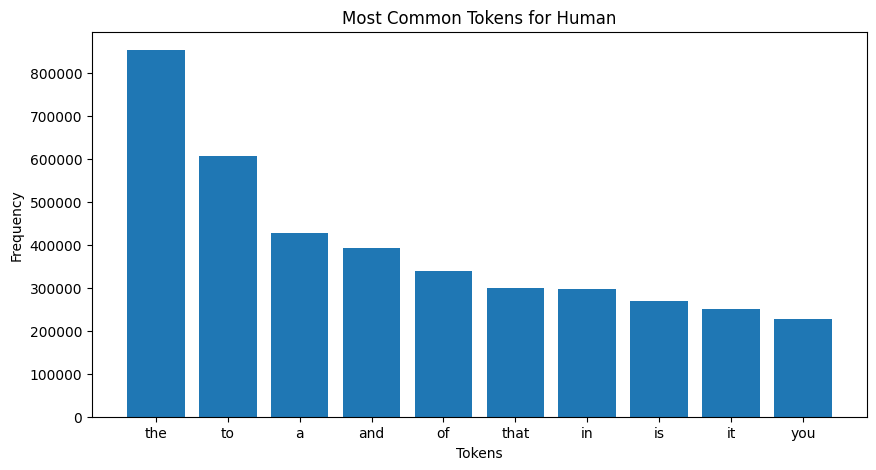

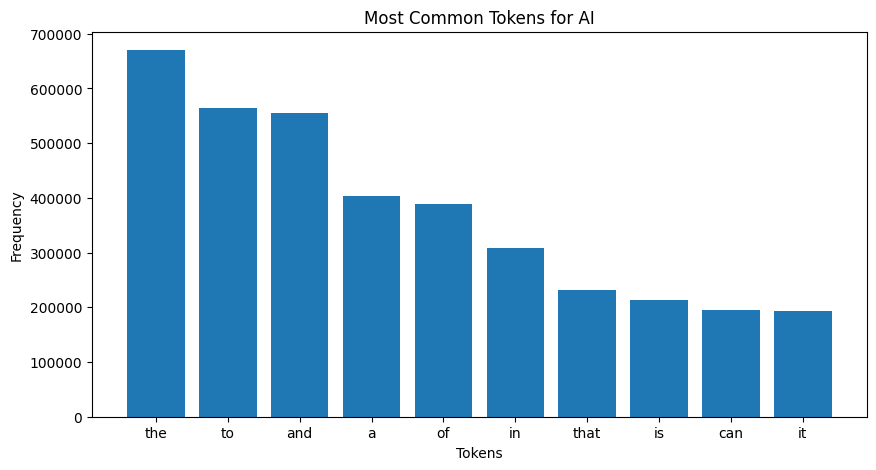

In [ ]:
# Function to plot the most common tokens by class
import string
def plot_common_tokens(df, class_value):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    # Filtering out tokens that are punctuation
    token_freq = Counter(token for tokens in df_class['tokens'] for token in tokens if token not in string.punctuation)

    common_tokens = token_freq.most_common(10)
    tokens, counts = zip(*common_tokens)

    plt.figure(figsize=(10, 5))
    plt.bar(tokens, counts)
    plt.title(f'Most Common Tokens for {class_map[class_value]}')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.show()

# Plotting for AI and not AI
plot_common_tokens(df_visualization, 0)
plot_common_tokens(df_visualization, 1)

In [ ]:
def pad_collate_fn(batch):
    input_ids, lengths, labels = zip(*batch)
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=PAD_IDX)
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)
    lengths, perm_idx = lengths.sort(0, descending=True)
    input_ids = input_ids[perm_idx]
    labels = labels[perm_idx]
    return input_ids, lengths, labels

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = bert_tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)
        length = input_ids.size(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, length, label

In [ ]:
# train (80%) + test (20%)
texts_temp, texts_test, labels_temp, labels_test = train_test_split(
    df['text'], df['generated'], test_size=0.2, random_state=42, stratify=df['generated'])

#  train -> validation (20% of 80% = 16% total)
texts_train, texts_val, labels_train, labels_val = train_test_split(
    texts_temp, labels_temp, test_size=0.2, random_state=42, stratify=labels_temp)
# texts_train, labels_train → 64%
# texts_val, labels_val → 16%
# texts_test, labels_test → 20%


# Build datasets
train_dataset = TextDataset(texts_train.tolist(), labels_train.tolist())
val_dataset   = TextDataset(texts_val.tolist(), labels_val.tolist())
test_dataset  = TextDataset(texts_test.tolist(), labels_test.tolist())

# Build DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_fn)


In [ ]:
def pad_collate_fn(batch):
    input_ids, lengths, labels = zip(*batch)
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=PAD_IDX)
    lengths = torch.tensor(lengths)
    labels = torch.tensor(labels)
    lengths, perm_idx = lengths.sort(0, descending=True)
    input_ids = input_ids[perm_idx]
    labels = labels[perm_idx]
    return input_ids, lengths, labels

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# Embedding + PackedSequence
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)  # [B, T] -> [B, T, D]
        packed_input = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True)
        _, (hidden, _) = self.lstm(packed_input)
        out = self.dropout(hidden[-1])
        return torch.sigmoid(self.fc(out).squeeze(1))

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for input_ids, lengths, labels in tqdm(train_loader):
            input_ids, lengths, labels = input_ids.to(device), lengths.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(input_ids, lengths)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # 驗證
        model.eval()
        total_loss, total_correct, total_count = 0, 0, 0
        with torch.no_grad():
            for input_ids, lengths, labels in val_loader:
                input_ids, lengths, labels = input_ids.to(device), lengths.to(device), labels.to(device)
                preds = model(input_ids, lengths)
                loss = criterion(preds, labels)
                total_loss += loss.item() * labels.size(0)
                total_correct += (torch.round(preds) == labels).sum().item()
                total_count += labels.size(0)
        val_losses.append(total_loss / total_count)
        val_accuracies.append(total_correct / total_count)
        print(f"Epoch {epoch+1}: Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")
    return train_losses, val_losses, val_accuracies


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def evaluate_model(test_loader, model, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_labels = 0, 0, 0
        all_preds, all_labels = [], []
        for input_ids, lengths, labels in test_loader:
            input_ids, lengths, labels = input_ids.to(device), lengths.to(device), labels.to(device)
            preds = model(input_ids, lengths)
            loss = criterion(preds, labels)
            total_loss += loss.item() * labels.size(0)
            total_correct += (torch.round(preds) == labels).sum().item()
            total_labels += labels.size(0)
            all_preds.extend(torch.round(preds).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels
        conf_matrix = confusion_matrix(all_labels, all_preds)
        print(classification_report(all_labels, all_preds))
        return avg_loss, avg_acc, conf_matrix

### LSTM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMClassifier(vocab_size=bert_tokenizer.vocab_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters())
train_losses, val_losses, val_accuracies = train_model(lstm_model, train_loader, val_loader, criterion, optimizer, device)


100%|██████████| 2000/2000 [07:19<00:00,  4.55it/s]


Epoch 1: Val Loss: 0.1189, Val Acc: 96.53%


100%|██████████| 2000/2000 [07:21<00:00,  4.53it/s]


Epoch 2: Val Loss: 0.0849, Val Acc: 97.92%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 3: Val Loss: 0.0435, Val Acc: 98.75%


100%|██████████| 2000/2000 [07:23<00:00,  4.51it/s]


Epoch 4: Val Loss: 0.0360, Val Acc: 98.90%


100%|██████████| 2000/2000 [07:22<00:00,  4.52it/s]


Epoch 5: Val Loss: 0.0312, Val Acc: 99.09%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 6: Val Loss: 0.0306, Val Acc: 99.14%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 7: Val Loss: 0.0264, Val Acc: 99.32%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 8: Val Loss: 0.0281, Val Acc: 99.31%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 9: Val Loss: 0.0291, Val Acc: 99.43%


100%|██████████| 2000/2000 [07:10<00:00,  4.64it/s]


Epoch 10: Val Loss: 0.0405, Val Acc: 99.24%


100%|██████████| 2000/2000 [07:19<00:00,  4.56it/s]


Epoch 11: Val Loss: 0.0304, Val Acc: 99.42%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 12: Val Loss: 0.0328, Val Acc: 99.41%


100%|██████████| 2000/2000 [07:23<00:00,  4.51it/s]


Epoch 13: Val Loss: 0.0382, Val Acc: 99.36%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 14: Val Loss: 0.0262, Val Acc: 99.43%


100%|██████████| 2000/2000 [07:21<00:00,  4.53it/s]


Epoch 15: Val Loss: 0.0312, Val Acc: 99.51%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 16: Val Loss: 0.0321, Val Acc: 99.34%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 17: Val Loss: 0.0348, Val Acc: 99.48%


100%|██████████| 2000/2000 [07:23<00:00,  4.51it/s]


Epoch 18: Val Loss: 0.0367, Val Acc: 99.51%


100%|██████████| 2000/2000 [07:23<00:00,  4.51it/s]


Epoch 19: Val Loss: 0.0348, Val Acc: 99.48%


100%|██████████| 2000/2000 [07:22<00:00,  4.52it/s]


Epoch 20: Val Loss: 0.0354, Val Acc: 99.44%


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     10000
         1.0       0.99      1.00      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

Test Loss: 0.0368, Test Accuracy: 99.42%


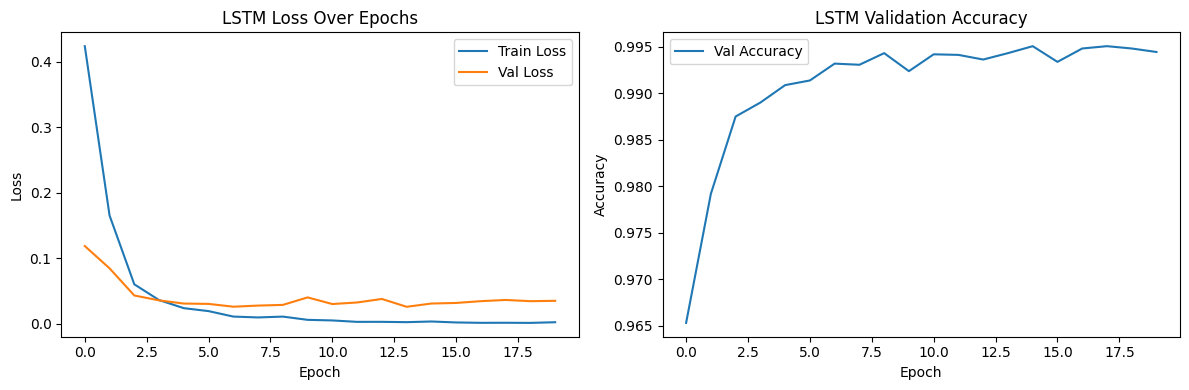

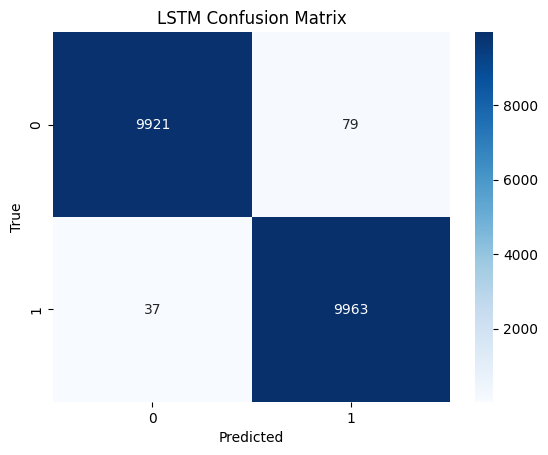

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, lstm_model, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LSTM Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()


### Auto_LSTM

In [ ]:
class AutoLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, embedding_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)  # [B, T, D]
        packed_input = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True)
        _, (hidden, _) = self.encoder(packed_input)  # [1, B, H]

        decoder_input = hidden.repeat(embedded.size(1), 1, 1).transpose(0, 1)  # [B, T, H]
        decoded_output, _ = self.decoder(decoder_input)  # [B, T, D]（可加重建 loss）

        out = self.dropout(hidden.squeeze(0))  # [B, H]
        return torch.sigmoid(self.fc(out).squeeze(1))  # [B]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autolstm_model = AutoLSTMClassifier(vocab_size=bert_tokenizer.vocab_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(autolstm_model.parameters())
train_losses, val_losses, val_accuracies = train_model(autolstm_model, train_loader, val_loader, criterion, optimizer, device)

100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 1: Val Loss: 0.1046, Val Acc: 96.81%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 2: Val Loss: 0.0546, Val Acc: 98.32%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 3: Val Loss: 0.0302, Val Acc: 99.11%


100%|██████████| 2000/2000 [07:34<00:00,  4.40it/s]


Epoch 4: Val Loss: 0.0292, Val Acc: 99.19%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 5: Val Loss: 0.0267, Val Acc: 99.24%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 6: Val Loss: 0.0272, Val Acc: 99.28%


100%|██████████| 2000/2000 [07:35<00:00,  4.40it/s]


Epoch 7: Val Loss: 0.0272, Val Acc: 99.40%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 8: Val Loss: 0.0284, Val Acc: 99.46%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 9: Val Loss: 0.0316, Val Acc: 99.41%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 10: Val Loss: 0.0359, Val Acc: 99.39%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 11: Val Loss: 0.0312, Val Acc: 99.44%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 12: Val Loss: 0.0383, Val Acc: 99.17%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 13: Val Loss: 0.0352, Val Acc: 99.49%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 14: Val Loss: 0.0334, Val Acc: 99.41%


100%|██████████| 2000/2000 [07:34<00:00,  4.40it/s]


Epoch 15: Val Loss: 0.0373, Val Acc: 99.42%


100%|██████████| 2000/2000 [07:34<00:00,  4.40it/s]


Epoch 16: Val Loss: 0.0374, Val Acc: 99.22%


100%|██████████| 2000/2000 [07:34<00:00,  4.40it/s]


Epoch 17: Val Loss: 0.0420, Val Acc: 99.42%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 18: Val Loss: 0.0359, Val Acc: 99.46%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 19: Val Loss: 0.0316, Val Acc: 99.49%


100%|██████████| 2000/2000 [07:35<00:00,  4.39it/s]


Epoch 20: Val Loss: 0.0387, Val Acc: 99.49%


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     10000
         1.0       1.00      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

Test Loss: 0.0333, Test Accuracy: 99.48%


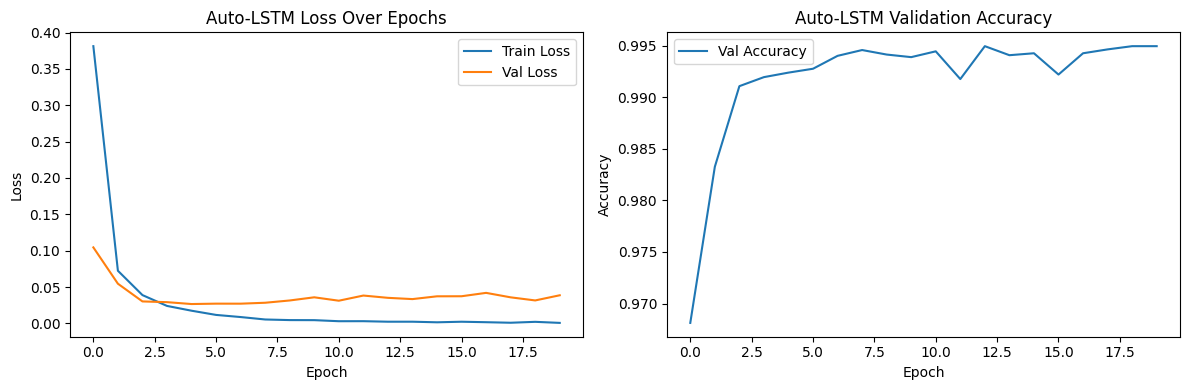

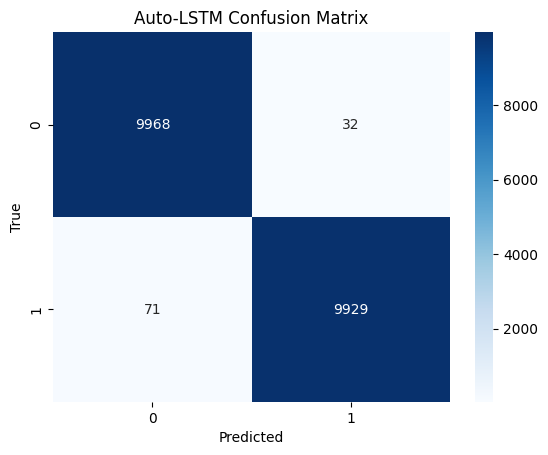

In [ ]:
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, autolstm_model, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Auto-LSTM Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Auto-LSTM Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Auto-LSTM Confusion Matrix')
plt.show()

### CNN-LSTM

In [ ]:
import torch.nn.functional as F

class CNNLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, num_filters=128, kernel_size=3, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)

        # CNN 卷積層
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)

        # LSTM
        self.lstm = nn.LSTM(num_filters, hidden_dim, batch_first=True)

        # Dropout & 線性層
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, input_ids, lengths):
        embedded = self.embedding(input_ids)  # [B, T, D]

        # CNN expects: [B, D, T]  → output: [B, F, T]
        conv_input = embedded.permute(0, 2, 1)
        conv_output = F.relu(self.conv(conv_input)).permute(0, 2, 1)  # [B, T, F]

        # Packed LSTM input
        packed_input = pack_padded_sequence(conv_output, lengths.cpu(), batch_first=True)
        _, (hidden, _) = self.lstm(packed_input)  # hidden: [1, B, H]

        out = self.dropout(hidden[-1])
        return torch.sigmoid(self.fc(out).squeeze(1))  # [B]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnnlstm_model = CNNLSTMClassifier(vocab_size=bert_tokenizer.vocab_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnnlstm_model.parameters())
train_losses, val_losses, val_accuracies = train_model(cnnlstm_model, train_loader, val_loader, criterion, optimizer, device)

100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 1: Val Loss: 0.0718, Val Acc: 97.87%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 2: Val Loss: 0.0501, Val Acc: 98.38%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 3: Val Loss: 0.0504, Val Acc: 98.32%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 4: Val Loss: 0.0375, Val Acc: 98.76%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 5: Val Loss: 0.0590, Val Acc: 98.19%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 6: Val Loss: 0.0296, Val Acc: 99.14%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 7: Val Loss: 0.0263, Val Acc: 99.16%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 8: Val Loss: 0.0298, Val Acc: 99.28%


100%|██████████| 2000/2000 [07:24<00:00,  4.50it/s]


Epoch 9: Val Loss: 0.0256, Val Acc: 99.22%


100%|██████████| 2000/2000 [07:22<00:00,  4.52it/s]


Epoch 10: Val Loss: 0.0266, Val Acc: 99.37%


100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


Epoch 11: Val Loss: 0.0274, Val Acc: 99.25%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 12: Val Loss: 0.0327, Val Acc: 99.34%


100%|██████████| 2000/2000 [07:27<00:00,  4.47it/s]


Epoch 13: Val Loss: 0.0277, Val Acc: 99.40%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 14: Val Loss: 0.0286, Val Acc: 99.34%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 15: Val Loss: 0.0301, Val Acc: 99.41%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 16: Val Loss: 0.0315, Val Acc: 99.42%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 17: Val Loss: 0.0294, Val Acc: 99.44%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 18: Val Loss: 0.0284, Val Acc: 99.44%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 19: Val Loss: 0.0299, Val Acc: 99.47%


100%|██████████| 2000/2000 [07:26<00:00,  4.48it/s]


Epoch 20: Val Loss: 0.0308, Val Acc: 99.44%


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     10000
         1.0       0.99      0.99      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000

Test Loss: 0.0300, Test Accuracy: 99.41%


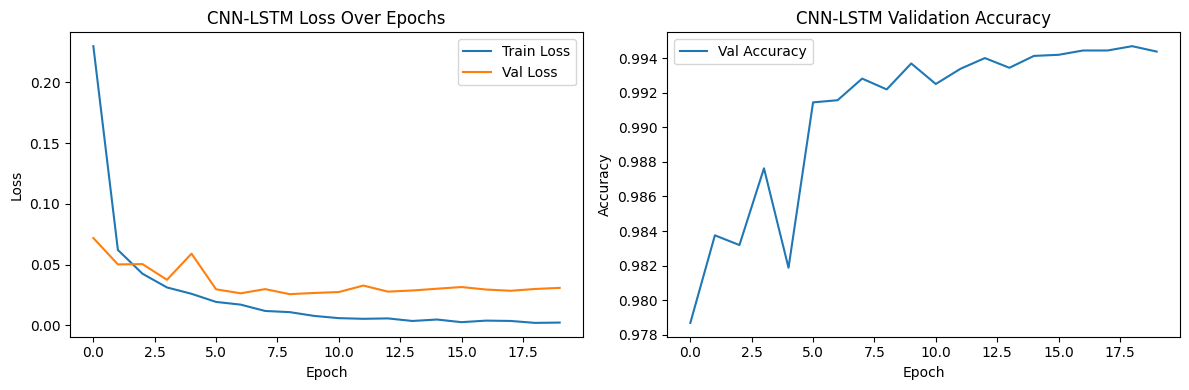

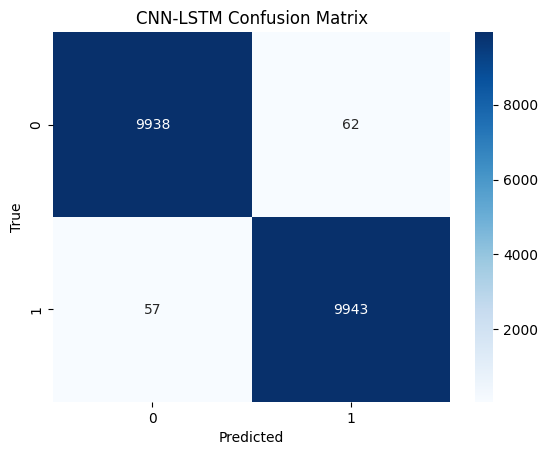

In [ ]:
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, cnnlstm_model, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN-LSTM Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN-LSTM Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN-LSTM Confusion Matrix')
plt.show()